## Importing packages

In [1]:
import io
import requests
import os
import sys
import math
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import random
import copy
import keras.backend
import multiprocessing as mp
%matplotlib inline

from programs.functions import *
from programs.sklearn_models import *
from programs.w_models import *
from programs.select_vars_gmm import *
from programs.dataset_functions import *

Using TensorFlow backend.


In [2]:
random.seed(42)
np.random.seed(42)

## Setting up datasets

Downloading datasets

In [3]:
dataset_names=['abalone','ailerons','bank32nh','cal_housing','cpu_act','delta_ailerons',
               'elevators', 'fried_delve','puma32H', 'winequality' ] 

In [4]:
data={}
for name in dataset_names: data[name]=download_dataset(name) #get_X_y(, scale=True)

- *** abalone *** dataset shape= (4177, 9)
- *** ailerons *** dataset shape= (13750, 41)
- *** bank32nh *** dataset shape= (8192, 34)
- *** cal_housing *** dataset shape= (20640, 9)
- *** cpu_act *** dataset shape= (8192, 22)
- *** delta_ailerons *** dataset shape= (7130, 6)
- *** elevators *** dataset shape= (16599, 19)
- *** fried_delve *** dataset shape= (40769, 11)
- *** puma32H *** dataset shape= (8192, 33)
- *** winequality *** dataset shape= (6497, 12)


In [5]:
for name in dataset_names: 
    n = data[name].shape[0]
    index = np.random.choice(n, min(8000,n), replace=False)
    data[name]=data[name].iloc[index,:]

As we are going to work only with continous features, then we remove the categorical features:

In [6]:
#Excluindo variável categórica
data['abalone']=data['abalone'].iloc[:,1:]

Get X and y:

In [7]:
for name in dataset_names: data[name]=get_X_y(data[name], scale=False) #

Expanding X

In [8]:
for name in dataset_names:
    n,d=data[name][0].shape
    
    if d<40:
        data[name][0]=np.hstack((data[name][0], np.random.normal(0,1,n*(32-d)).reshape((n,-1))))

In [9]:
from sklearn.preprocessing import StandardScaler

for name in dataset_names: 
    scaler=StandardScaler()
    data[name][0]=scaler.fit_transform(data[name][0])
    
    scaler=StandardScaler()
    data[name][1]=scaler.fit_transform(data[name][1].reshape((-1,1))).squeeze()
    print(name,data[name][0].shape)

abalone (4177, 32)
ailerons (8000, 40)
bank32nh (8000, 32)
cal_housing (8000, 32)
cpu_act (8000, 32)
delta_ailerons (7129, 32)
elevators (8000, 32)
fried_delve (8000, 32)
puma32H (8000, 32)
winequality (6497, 32)


Splitting data

In [10]:
B=100

In [11]:
%%time
BB=2*B*48
output={}

for name in dataset_names: 
    print("***",name,"***")
    pool = mp.Pool(mp.cpu_count())
    output[name] = pool.starmap(aval_reg, [(b, data[name][0], data[name][1]) for b in range(BB)]) #starmap
    pool.close()

*** abalone ***
*** ailerons ***
*** bank32nh ***
*** cal_housing ***
*** cpu_act ***
*** delta_ailerons ***
*** elevators ***
*** fried_delve ***
*** puma32H ***
*** winequality ***
CPU times: user 24.4 s, sys: 1min 5s, total: 1min 29s
Wall time: 1h 14min 34s



************ abalone ************
Relative Error


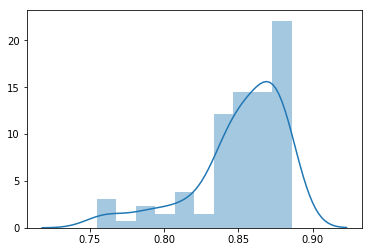


ESS (%)


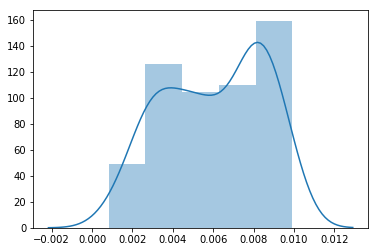


ESS (n)


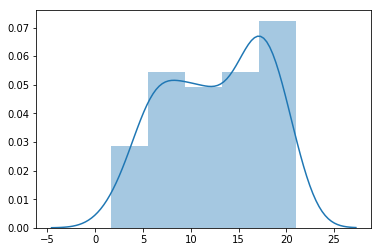


Max w


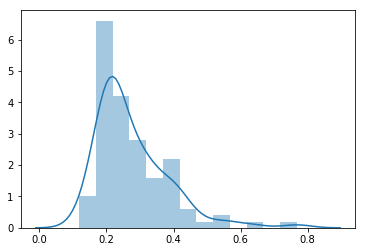


Actual training sample size


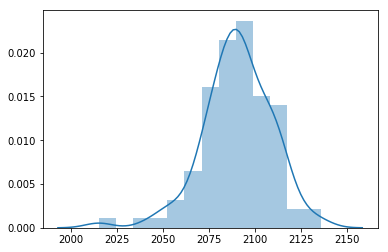


************ ailerons ************
Relative Error


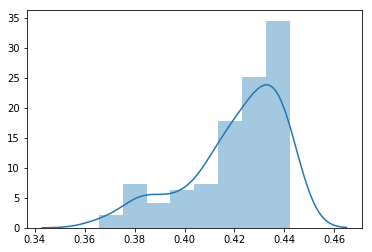


ESS (%)


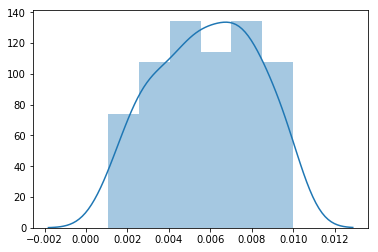


ESS (n)


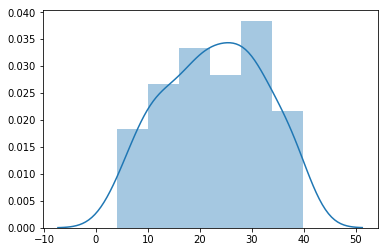


Max w


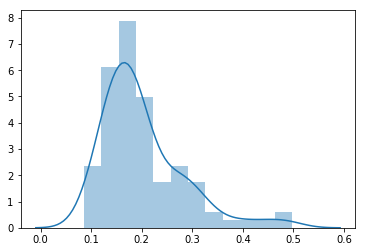


Actual training sample size


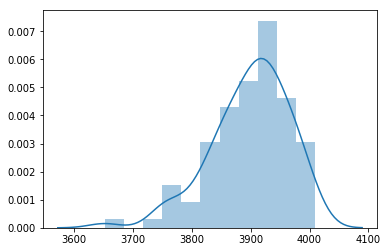


************ bank32nh ************
Relative Error


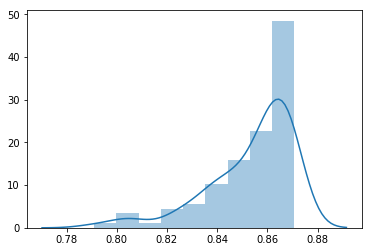


ESS (%)


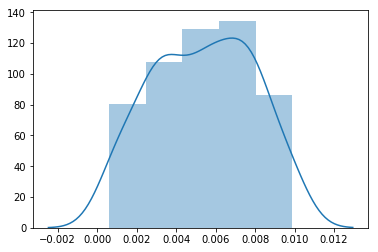


ESS (n)


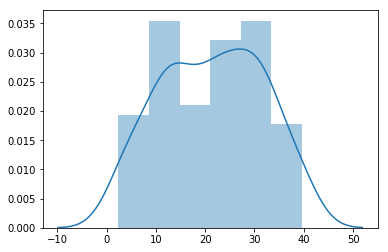


Max w


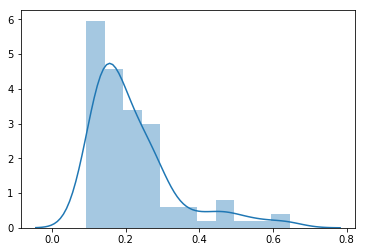


Actual training sample size


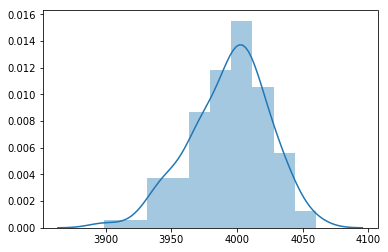


************ cal_housing ************
Relative Error


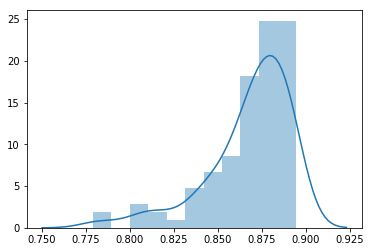


ESS (%)


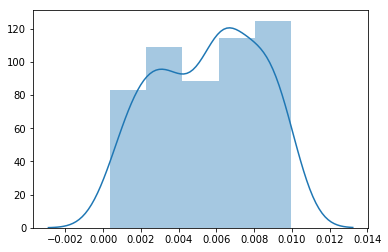


ESS (n)


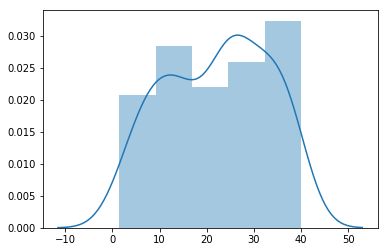


Max w


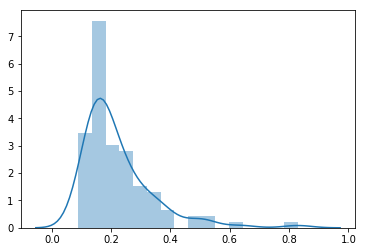


Actual training sample size


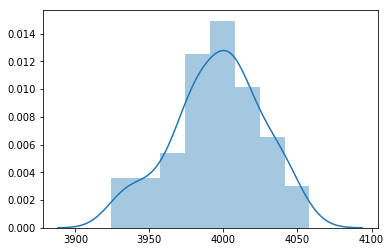


************ cpu_act ************
Relative Error


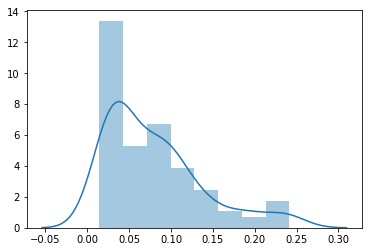


ESS (%)


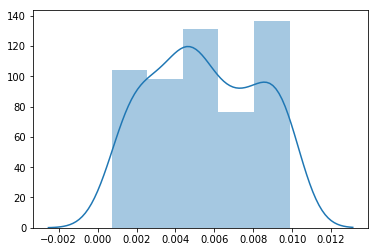


ESS (n)


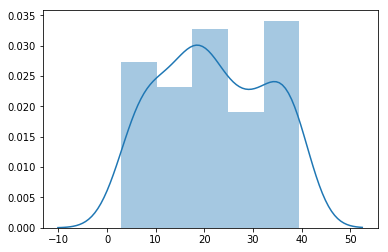


Max w


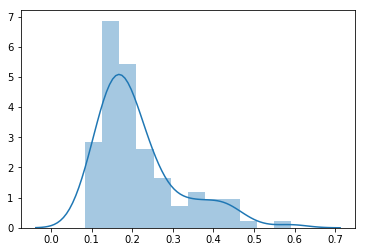


Actual training sample size


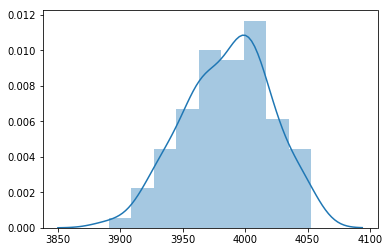


************ delta_ailerons ************
Relative Error


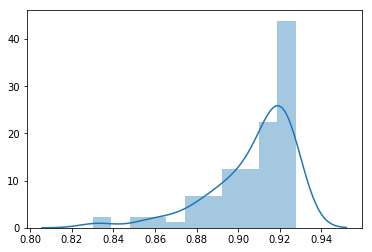


ESS (%)


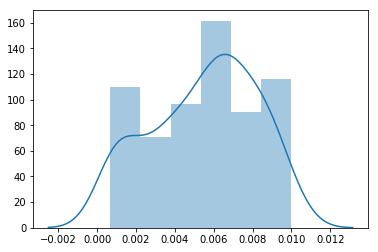


ESS (n)


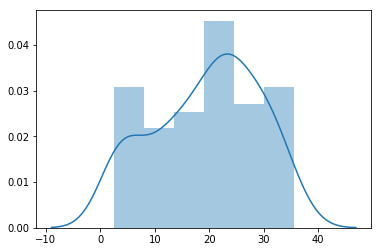


Max w


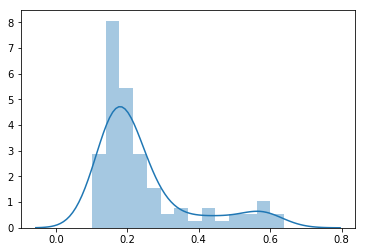


Actual training sample size


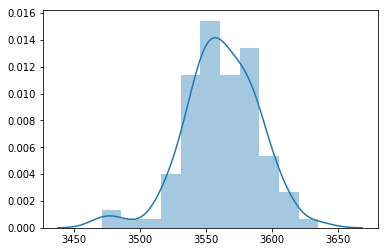


************ elevators ************
Relative Error


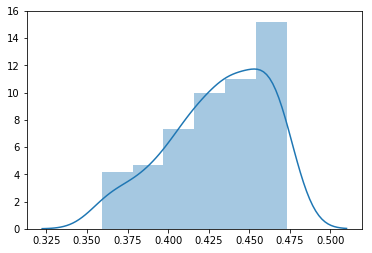


ESS (%)


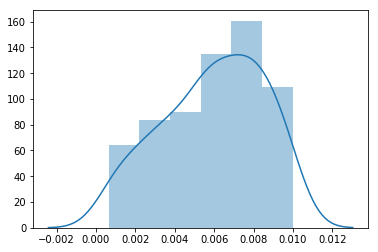


ESS (n)


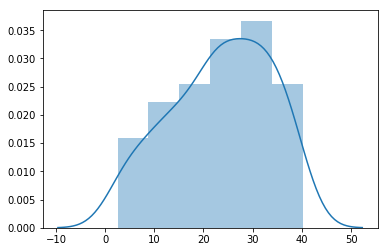


Max w


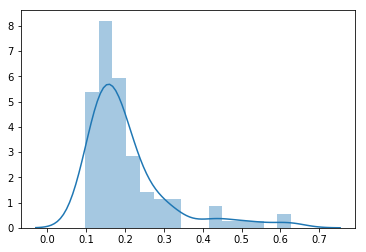


Actual training sample size


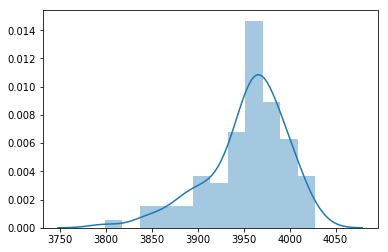


************ fried_delve ************
Relative Error


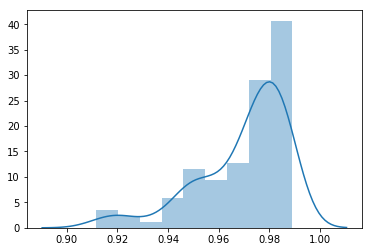


ESS (%)


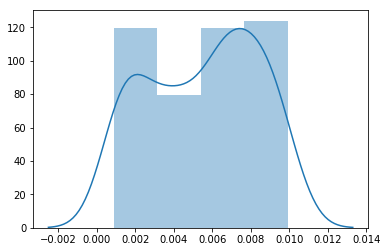


ESS (n)


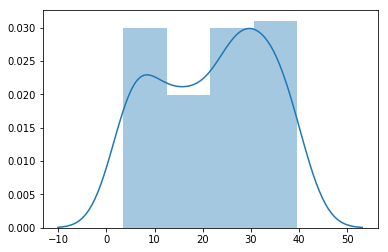


Max w


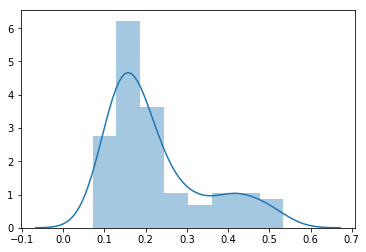


Actual training sample size


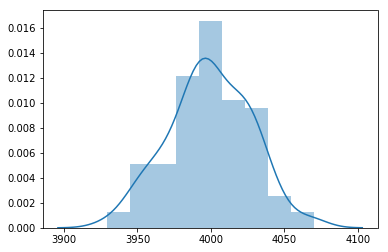


************ puma32H ************
Relative Error


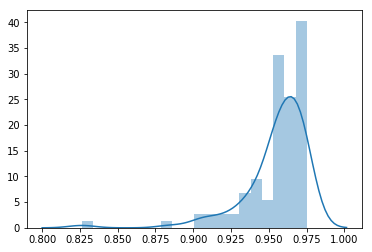


ESS (%)


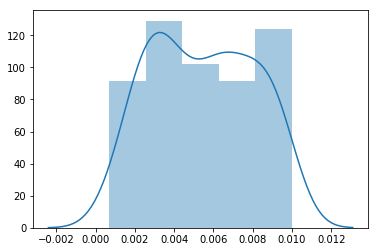


ESS (n)


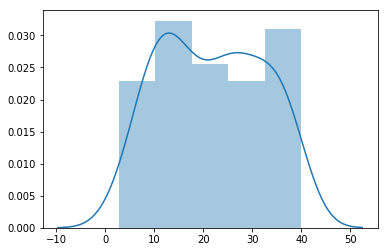


Max w


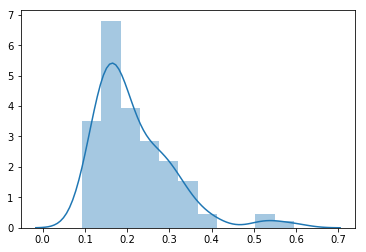


Actual training sample size


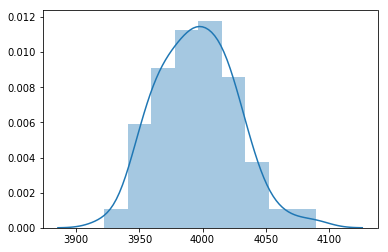


************ winequality ************
Relative Error


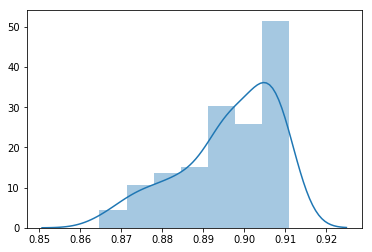


ESS (%)


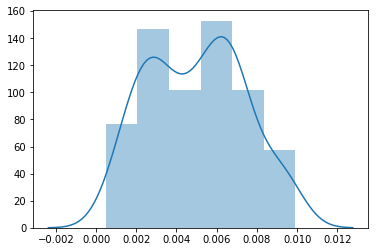


ESS (n)


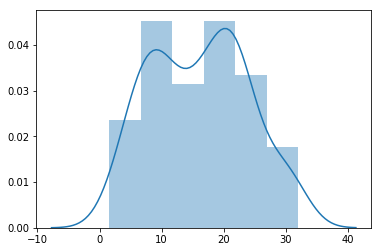


Max w


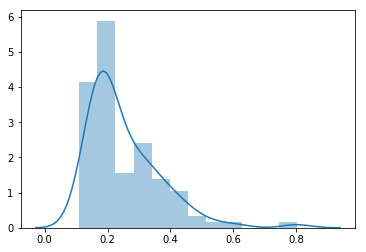


Actual training sample size


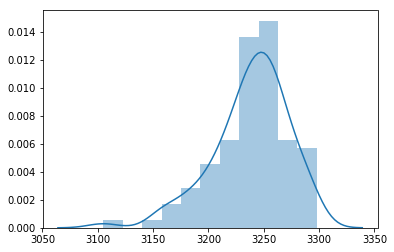

CPU times: user 21 s, sys: 13 s, total: 34 s
Wall time: 10.9 s


In [12]:
%%time

data_split={}

###     
for name in dataset_names: 
    
    arr=np.array(output[name])
    index_sort=arr[:,0].argsort()
    data_split[name]={}
    
    ###
    error_ratios=[]
    ess_percs=[]
    ess_ns=[]
    w_maxs=[]
    ns=[]
    
    ###
    for b in range(B):

        error_ratio=arr[index_sort[b]][0]
        ess_perc=arr[index_sort[b]][1]
        ess_n=arr[index_sort[b]][2] 
        n=arr[index_sort[b]][3]
        s=arr[index_sort[b]][4]
        w=arr[index_sort[b]][5]
        data_split[name][b]={}

        data_split[name][b]['train']=data[name][0][s], data[name][1][s], w[s]
        data_split[name][b]['test']=data[name][0][~s], data[name][1][~s], w[~s]
        
        error_ratios.append(error_ratio)
        ess_percs.append(ess_perc)
        ess_ns.append(ess_n)
        w_maxs.append(np.max(w[s])/np.sum(w[s]))
        ns.append(n)
        
    
    print("\n************",name,"************")
    print("Relative Error")
    sns.distplot(error_ratios)
    plt.show()
    
    print("\nESS (%)")
    sns.distplot(ess_percs)
    plt.show()
    
    print("\nESS (n)")
    sns.distplot(ess_ns)
    plt.show()
    
    print("\nMax w")
    sns.distplot(w_maxs)
    plt.show()
    
    print("\nActual training sample size")
    sns.distplot(ns)
    plt.show()

### All features - true weights

In [13]:
def experiments_true(b):
    
    #Datasets
    X_test, y_test=copy.deepcopy(data_split[name][b]['test'][0]), copy.deepcopy(data_split[name][b]['test'][1])
    X_train, y_train=copy.deepcopy(data_split[name][b]['train'][0]),copy.deepcopy(data_split[name][b]['train'][1])
    
     
    #####################################
    ######## Weighted Experiment ########
    #####################################

    #Get w
    w = copy.deepcopy(data_split[name][b]['train'][2])
    
    #Training
    w_norm=w/np.sum(w)
    w_norm1=copy.deepcopy(w_norm)
    model1 = DT_reg()
    model1 = model1.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat1 = model1.predict(X_test)
    error1 = mean_squared_error(y_hat1,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_1 = np.sum(w_norm[index])/np.sum(w_norm)

    #ESS
    n=w.shape[0]
    ess1=np.round(1/np.sum(w_norm**2), 2) 
    
    
    ################################################
    ######## Weighted (Adaptive) Experiment ########
    ################################################
    
    #Choosing best a (smoother)
    alphas=[.1,.2,.3,.4,.5,.6,.7,.8,.9]

    best_a=None
    best_error=math.inf
    
    X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
    w_train, w_test, _, _ = train_test_split(w, w, test_size=0.5, random_state=42)
    
    for a in alphas:
        model = DT_reg()
        model = model.fit(X_train_train,y_train_train,sample_weight=w_train**a)

        y_hat = model.predict(X_train_test)
        error = mean_squared_error(y_hat, y_train_test, sample_weight=w_test)

        if error<best_error:
            best_error=error
            best_a=a
    
    #Training
    w_norm=w**best_a/np.sum(w**best_a)
    w_norm2=copy.deepcopy(w_norm)
    model2 = DT_reg()
    model2 = model2.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat2 = model2.predict(X_test)
    error2 = mean_squared_error(y_hat2,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_2 = np.sum((w_norm)[index])/np.sum(w_norm)

    #ESS
    ess2=np.round(1/np.sum((w_norm)**2), 2)

    
    #Output
    return None, [b, error1, w_10_1, ess1/n, X_train.shape[1], w_norm1], [b, error2, w_10_2, ess2/n, X_train.shape[1], w_norm2]

In [14]:
%%time 
output={}

for name in dataset_names: 
    print("***",name,"***")

    pool = mp.Pool(mp.cpu_count())
    output[name] = pool.map_async(experiments_true, [(b) for b in range(B)]).get()
    pool.close()

*** abalone ***
*** ailerons ***
*** bank32nh ***
*** cal_housing ***
*** cpu_act ***
*** delta_ailerons ***
*** elevators ***
*** fried_delve ***
*** puma32H ***
*** winequality ***
CPU times: user 1.31 s, sys: 1min 8s, total: 1min 9s
Wall time: 2min 29s


In [15]:
experiments_true1_output={}
experiments_true2_output={}

for name in dataset_names: 
    experiments_true1_output[name]=[] 
    experiments_true2_output[name]=[]
    
    for b in range(B):
        experiments_true1_output[name].append(output[name][b][1][:-1])
        experiments_true2_output[name].append(output[name][b][2][:-1])
         
    experiments_true1_output[name]=np.array(experiments_true1_output[name])
    experiments_true2_output[name]=np.array(experiments_true2_output[name])

In [16]:
f = open("outputs/experiments_true1_output_reg.pkl","wb")
pickle.dump(experiments_true1_output,f)
f.close()

f = open("outputs/experiments_true2_output_reg.pkl","wb")
pickle.dump(experiments_true2_output,f)
f.close()

### All features - estimated weights

In [17]:
def experiments_0_1_2(b):
    
    #Datasets
    X_test, y_test=copy.deepcopy(data_split[name][b]['test'][0]), copy.deepcopy(data_split[name][b]['test'][1])
    X_train, y_train=copy.deepcopy(data_split[name][b]['train'][0]),copy.deepcopy(data_split[name][b]['train'][1])
    
    
    #####################################
    ####### Unweighted Experiment #######
    #####################################
    
    #Training
    model0=DT_reg()
    model0=model0.fit(X_train,y_train,sample_weight=None)
    
    #Testing
    y_hat0=model0.predict(X_test)
    error0=mean_squared_error(y_hat0,y_test)
    
    
    #####################################
    ######## Weighted Experiment ########
    #####################################

    #Estimate w
    model_w = Poly_Logreg_w(2) 
    model_w.fit(X_test, X_train)
    w = model_w.predict(X_train)
    
    #Training
    w_norm=w/np.sum(w)
    w_norm1=copy.deepcopy(w_norm)
    model1 = DT_reg()
    model1 = model1.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat1 = model1.predict(X_test)
    error1 = mean_squared_error(y_hat1,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_1 = np.sum(w_norm[index])/np.sum(w_norm)

    #ESS
    n=w.shape[0]
    ess1=np.round(1/np.sum(w_norm**2), 2) 
    
    
    ################################################
    ######## Weighted (Adaptive) Experiment ########
    ################################################
    
    #Choosing best a (smoother)
    alphas=[.1,.2,.3,.4,.5,.6,.7,.8,.9]

    best_a=None
    best_error=math.inf
    
    X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
    w_train, w_test, _, _ = train_test_split(w, w, test_size=0.5, random_state=42)
    
    for a in alphas:
        model = DT_reg()
        model = model.fit(X_train_train,y_train_train,sample_weight=w_train**a)

        y_hat = model.predict(X_train_test)
        error = mean_squared_error(y_hat, y_train_test, sample_weight=w_test)

        if error<best_error:
            best_error=error
            best_a=a
    
    #Training
    w_norm=w**best_a/np.sum(w**best_a)
    w_norm2=copy.deepcopy(w_norm)
    model2 = DT_reg()
    model2 = model2.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat2 = model2.predict(X_test)
    error2 = mean_squared_error(y_hat2,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_2 = np.sum((w_norm)[index])/np.sum(w_norm)

    #ESS
    ess2=np.round(1/np.sum((w_norm)**2), 2)

    
    #Output
    return [b, error0, .01 , 1, X_train.shape[1], None], [b, error1, w_10_1, ess1/n, X_train.shape[1], w_norm1], [b, error2, w_10_2, ess2/n, X_train.shape[1], w_norm2]

In [18]:
%%time 
output={}

for name in dataset_names: 
    print("***",name,"***")

    pool = mp.Pool(mp.cpu_count())
    output[name] = pool.map_async(experiments_0_1_2, [(b) for b in range(B)]).get()
    pool.close()

*** abalone ***
*** ailerons ***
*** bank32nh ***
*** cal_housing ***
*** cpu_act ***
*** delta_ailerons ***
*** elevators ***
*** fried_delve ***
*** puma32H ***
*** winequality ***
CPU times: user 3.41 s, sys: 1min 2s, total: 1min 5s
Wall time: 10min 52s


In [19]:
experiments_0_output={}
experiments_1_output={}
experiments_2_output={}

for name in dataset_names: 
    experiments_0_output[name]=[]
    experiments_1_output[name]=[] 
    experiments_2_output[name]=[]
    
    for b in range(B):
        experiments_0_output[name].append(output[name][b][0][:-1])
        experiments_1_output[name].append(output[name][b][1][:-1])
        experiments_2_output[name].append(output[name][b][2][:-1])
        
    experiments_0_output[name]=np.array(experiments_0_output[name])
    experiments_1_output[name]=np.array(experiments_1_output[name])
    experiments_2_output[name]=np.array(experiments_2_output[name])

In [20]:
f = open("outputs/experiments_0_output_reg.pkl","wb")
pickle.dump(experiments_0_output,f)
f.close()

f = open("outputs/experiments_1_output_reg.pkl","wb")
pickle.dump(experiments_1_output,f)
f.close()

f = open("outputs/experiments_2_output_reg.pkl","wb")
pickle.dump(experiments_2_output,f)
f.close()

### Selected features - estimated weights

In [21]:
def gmm_scores(X_train,X_test,k):  
    clf = mixture.GaussianMixture(n_components=k, covariance_type='full')
    clf.fit(X_train)
    return [clf.score(X_test),clf.aic(X_test), clf.bic(X_test)]

In [22]:
def experiments_3_4_5(b):

    #Datasets
    X_test, y_test=copy.deepcopy(data_split[name][b]['test'][0]), copy.deepcopy(data_split[name][b]['test'][1])
    X_train, y_train=copy.deepcopy(data_split[name][b]['train'][0]),copy.deepcopy(data_split[name][b]['train'][1])
    
    #Fitting GMM for var selection
    X_gmm_train, X_gmm_test, y_gmm_train, y_gmm_test=train_test_split(X_train, y_train, test_size=0.5, random_state=42)
    Z_train=np.hstack((y_gmm_train.reshape((-1,1)), X_gmm_train))
    Z_test=np.hstack((y_gmm_test.reshape((-1,1)), X_gmm_test))
    aic_bic=np.array([gmm_scores(Z_train, Z_test, k) for k in list(range(1,15,1))])
    k_star=np.argmax(aic_bic[:,0])+1
    
    Z = np.hstack((y_train.reshape((-1,1)),X_train))
    gmm = mixture.GaussianMixture(n_components=k_star, covariance_type='full')
    gmm.fit(Z)

    #Selecting vars
    select=select_vars(gmm, d=15, stop=0.01)
    select.fit(X_train, y_train, verbose=False)    
    X_train=select.transform(X_train)
    X_test=select.transform(X_test)
    
    #####################################
    ####### Unweighted Experiment #######
    #####################################
    
    #Training
    model0=DT_reg()
    model0=model0.fit(X_train,y_train,sample_weight=None)
    
    #Testing
    y_hat0=model0.predict(X_test)
    error0=mean_squared_error(y_hat0,y_test)
    
    
    #####################################
    ######## Weighted Experiment ########
    #####################################

    #Estimate w
    model_w = Poly_Logreg_w(2) 
    model_w.fit(X_test, X_train)
    w = model_w.predict(X_train)
    
    #Training
    w_norm=w/np.sum(w)
    w_norm1=copy.deepcopy(w_norm)
    model1 = DT_reg()
    model1 = model1.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat1 = model1.predict(X_test)
    error1 = mean_squared_error(y_hat1,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_1 = np.sum(w_norm[index])/np.sum(w_norm)

    #ESS
    n=w.shape[0]
    ess1=np.round(1/np.sum(w_norm**2), 2) 
    
    
    ################################################
    ######## Weighted (Adaptive) Experiment ########
    ################################################
    
    #Choosing best a (smoother)
    alphas=[.1,.2,.3,.4,.5,.6,.7,.8,.9]

    best_a=None
    best_error=math.inf
    
    X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, test_size=0.5, random_state=42)
    w_train, w_test, _, _ = train_test_split(w, w, test_size=0.5, random_state=42)
    
    for a in alphas:
        model = DT_reg()
        model = model.fit(X_train_train,y_train_train,sample_weight=w_train**a)

        y_hat = model.predict(X_train_test)
        error = mean_squared_error(y_hat, y_train_test, sample_weight=w_test)

        if error<best_error:
            best_error=error
            best_a=a
    
    #Training
    w_norm=w**best_a/np.sum(w**best_a)
    w_norm2=copy.deepcopy(w_norm)
    model2 = DT_reg()
    model2 = model2.fit(X_train,y_train,sample_weight=w_norm)
    
    #Testing
    y_hat2 = model2.predict(X_test)
    error2 = mean_squared_error(y_hat2,y_test)
    
    #W_MAX
    n=w.shape[0]
    index = w.argsort()[-int(n/100):][::-1]
    w_10_2 = np.sum((w_norm)[index])/np.sum(w_norm)

    #ESS
    ess2=np.round(1/np.sum((w_norm)**2), 2)

    
    #Output
    return [b, error0, .01 , 1, X_train.shape[1],None], [b, error1, w_10_1, ess1/n, X_train.shape[1],w_norm1], [b, error2, w_10_2, ess2/n, X_train.shape[1],w_norm2]

In [23]:
%%time 
output={}

for name in dataset_names: 
    print("***",name,"***")

    pool = mp.Pool(mp.cpu_count())
    output[name] = pool.map_async(experiments_3_4_5, [(b) for b in range(B)]).get()
    pool.close()

*** abalone ***
*** ailerons ***
*** bank32nh ***
*** cal_housing ***
*** cpu_act ***
*** delta_ailerons ***
*** elevators ***
*** fried_delve ***
*** puma32H ***
*** winequality ***
CPU times: user 56.4 s, sys: 1min 50s, total: 2min 47s
Wall time: 4h 21min 53s


In [24]:
experiments_3_output={}
experiments_4_output={}
experiments_5_output={}

for name in dataset_names: 
    experiments_3_output[name]=[] 
    experiments_4_output[name]=[]
    experiments_5_output[name]=[]
    
    for b in range(B):
        experiments_3_output[name].append(output[name][b][0])
        experiments_4_output[name].append(output[name][b][1])
        experiments_5_output[name].append(output[name][b][2])
        
    experiments_3_output[name]=np.array(experiments_3_output[name])
    experiments_4_output[name]=np.array(experiments_4_output[name])
    experiments_5_output[name]=np.array(experiments_5_output[name])

In [25]:
f = open("outputs/experiments_3_output_reg.pkl","wb")
pickle.dump(experiments_3_output,f)
f.close()

f = open("outputs/experiments_4_output_reg.pkl","wb")
pickle.dump(experiments_4_output,f)
f.close()

f = open("outputs/experiments_5_output_reg.pkl","wb")
pickle.dump(experiments_5_output,f)
f.close()